<a href="https://colab.research.google.com/github/TitanSage02/Vox-Thymio/blob/main/v2/notebooks/classification_intention_robot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification d'intention pour Thymio - Notebook complet

Ce notebook contient toutes les étapes pour entraîner un modèle de classification d'intentions basé sur BERT, depuis l'exploration des données jusqu'à la sauvegarde du modèle.

## Étapes couvertes :
1. Chargement et exploration du jeu de données
2. Prétraitement du texte
3. Tokenization avec `BERT`
4. Entraînement du modèle
5. Évaluation sur un jeu de test
6. Sauvegarde du modèle

## 1. Chargement du jeu de données

In [5]:
import pandas as pd

# Chargement des données
df = pd.read_csv('Intent_dataset.csv')
df.head()

,text,label
0,Va en avant,avancer
1,Avance toi,avancer
2,Il faut aller devant,avancer
3,Mouvement vers l'avant,avancer
4,Déplace toi vers l'avant,avancer


## 2. Exploration des données

Nombre d'exemples : 1707


<Axes: title={'center': 'Répartition des intentions'}, xlabel='label'>

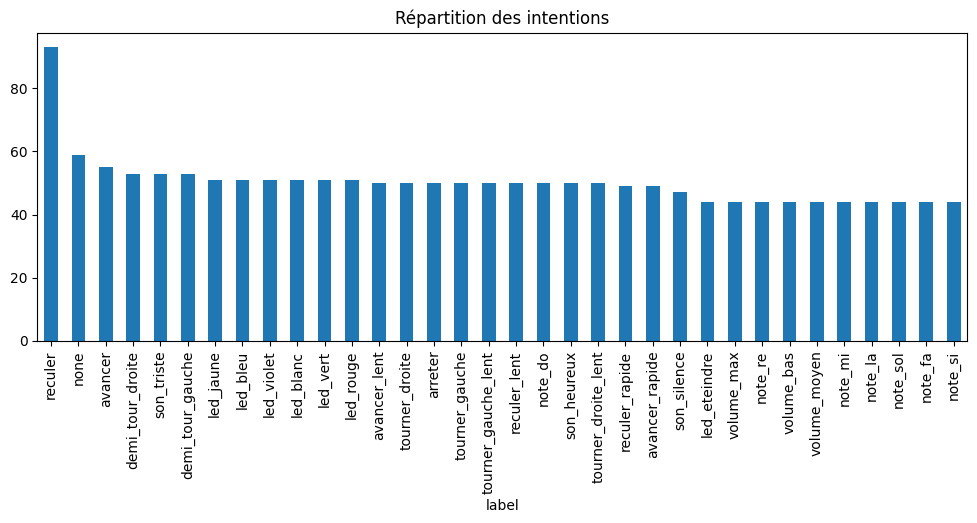

In [6]:
# Taille du jeu de données
print(f"Nombre d'exemples : {len(df)}")

# Répartition des classes
df['label'].value_counts().plot(kind='bar', figsize=(12,4), title="Répartition des intentions")

In [7]:
# On enlève les 40 échantillons de reculer avec random_state à 42
df = df.drop(df[(df['label'] == 'reculer')].sample(40, random_state=42).index)

<Axes: title={'center': 'Répartition des intentions'}, xlabel='label'>

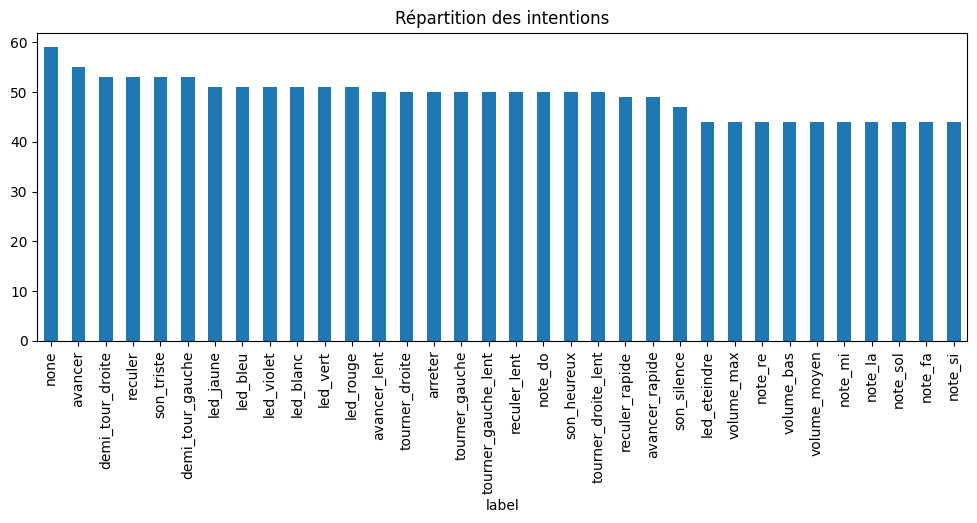

In [8]:
# Répartition des classes
df['label'].value_counts().plot(kind='bar', figsize=(12,4), title="Répartition des intentions")

## 3. Prétraitement du texte

In [9]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\sàâçéèêëîïôûùüÿñæœ'-]", '', text)
    return text

df['text'] = df['text'].apply(clean_text)

## 4. Préparation des données pour BERT

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

# Encodage des étiquettes
le = LabelEncoder() # One-Hot Encoding à voir après
df['label_id'] = le.fit_transform(df['label'])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label_id'], test_size=0.2, random_state=42)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## 5. Dataset Torch

In [11]:
import torch

class IntentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = IntentDataset(train_encodings, list(y_train))
test_dataset = IntentDataset(test_encodings, list(y_test))

## 6. Entraînement du modèle BERT

In [12]:
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.8 MB/s eta 0:00:00


In [14]:
from transformers import EarlyStoppingCallback
from transformers import BertForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np

# Define metrics
def compute_metrics(eval_pred):
    accuracy = evaluate.load("accuracy")
    f1 = evaluate.load("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]

    return {"accuracy": accuracy, "f1": f1}

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=25,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='/content/logs',
    logging_steps=5,
    report_to="none",
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="f1",  # Use f1 score to determine the best model
    greater_is_better=True # Higher f1 score is better
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] # Stop if f1 score doesn't improve for 3 epochs
)

trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.813000,1.960965,0.514970,0.462227
2,0.831400,0.971813,0.655689,0.614831
3,0.536800,0.648854,0.733533,0.692272
4,0.224400,0.534995,0.841317,0.829776
5,0.149300,0.448960,0.886228,0.884801
6,0.082200,0.481579,0.889222,0.889643
7,0.028900,0.435525,0.898204,0.898930
8,0.024100,0.478958,0.904192,0.905201
9,0.187000,0.524597,0.898204,0.899142
10,0.071300,0.547197,0.907186,0.907930


TrainOutput(global_step=2171, training_loss=0.4660928703041062, metrics={'train_runtime': 653.5033, 'train_samples_per_second': 50.994, 'train_steps_per_second': 6.389, 'total_flos': 142523796172992.0, 'train_loss': 0.4660928703041062, 'epoch': 13.0})

## 7. Évaluation

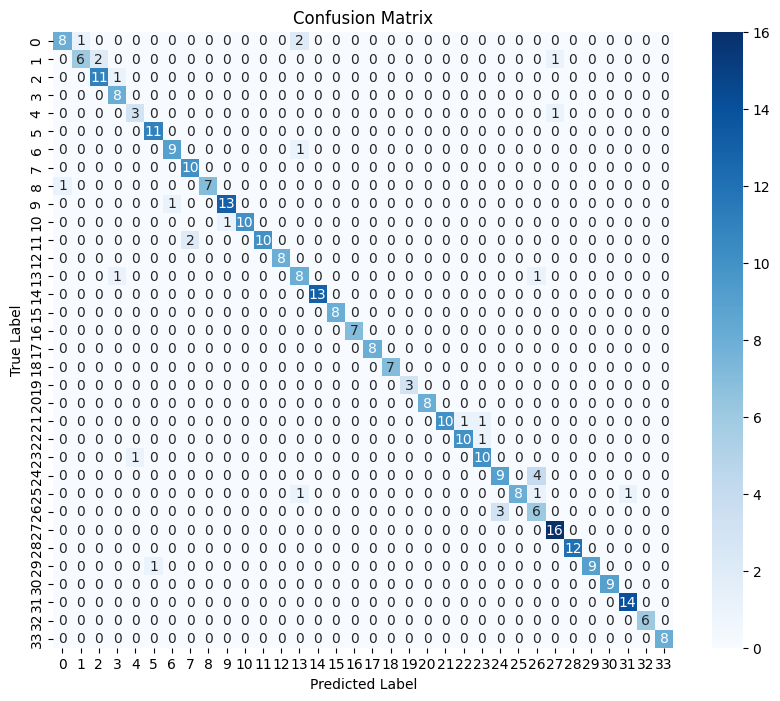

In [15]:
# Matrice de confusion

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test set
predictions = trainer.predict(test_dataset)

# Extract predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Evaluation du modèle

trainer.evaluate()

## 8. Sauvegarde du modèle et de l’encodeur de labels

In [ ]:
model.save_pretrained('./intent_model')
tokenizer.save_pretrained('./intent_model')

import joblib
joblib.dump(le, './intent_model/label_encoder.pkl')

## Prêt pour l'inférence !